# Tutorial - Solving Flight Scheduling Optimization using QAOA

Quantum computing has introduced a new approach for solving complex optimization problems. Notably, the **Quantum Approximate Optimization Algorithm (QAOA)** – a hybrid (quantum-classical) – has emerged as a promising candidate.
In this tutorial, we will see how QAOA can be applied to solve a real-world optimization problem, specifically, the tail-assignment problem – with **Qiskit**.

## Requirements

Before starting this tutorial, be sure you have the following installed:

* Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
* Qiskit Runtime v0.22 or later (`pip install qiskit-ibm-runtime`)
* Qiskit AER v0.15.0 or later (`pip install qiskit-aer`)

## The Tail-Assignment Problem

The tail-assignment problem is a complex combinatorial optimization challenge arising in the airline industry, specifically in aircraft scheduling tasks. The objective is to assign a specific aircraft (identified by its tail number), also called a *route*, to a sequence of flights while:

1. **Satisfying operational constraints** (e.g., maintenance schedules, turnaround times, crew availability).
2. **Minimizing operational costs** (e.g., fuel usage, delay penalties).

### Why Is It Hard?
The tail-assignment problem is classified as **NP-hard**. This means that as the number of flights and aircraft increases, finding an optimal solution becomes computationally infeasible for traditional algorithms due to exponential growth in complexity. A common classical approach to this problem is **column generation**, which breaks the problem into smaller subproblems to make it manageable.

### Mathematical Formulation
The tail-assignment problem can be formulated as the following integer linear program:

\begin{equation}
    \min\sum_{r\in R}c_rx_r,
\end{equation}

Such that

\begin{align}
    \sum_{r\in R}A_{fr}x_r =1,\quad &\forall f\in F,\\
    x_r\in\{0,1\},\quad &\forall r\in R,
\end{align}

Where:

- $R$: The set of all possible routes (sequences of flights assigned to an aircraft).
- $c_r$: The cost associated with route $r$.
- $F$: The set of all activities (e.g., individual flights or sequences of flights).
- $A_{fr}$: A binary indicator; $A_{fr} = 1$ if activity $f$ is part of route $r$, and $0$ otherwise.
- $x_r$: A binary decision variable; $x_r = 1$ if route $r$ is chosen in the solution, and $0$ otherwise.
  
### Simplified Problem for This Tutorial
For this tutorial, we focus on a simplified version of the problem where:

1. **Only one feasible solution exists per instance.** This eliminates the need to minimize costs ($c_r$) since it becomes irrelevant when there is a unique solution.
2. The problem reduces to solving the constraints:
\begin{equation}
    \sum_{r\in R}A_{fr}x_r =1,\quad \forall f\in F,
\end{equation}
which can be expressed compactly in matrix form as:
\begin{equation}
    A\vec{x}=\vec{1}
\end{equation}

- $A$: The constraint matrix.
- $\vec{x}$: A vector of binary decision variables.
- $\vec{1}$: A vector of ones (length equal to the number of flights).

### Connection to the Exact Cover Problem
This simplified tail-assignment problem is equivalent to the well-known [Exact Cover problem](https://en.wikipedia.org/wiki/Exact_cover). In Exact Cover, the goal is to select a subset of sets such that every element in the universal set is covered exactly once.

**Visual Example:**

<div align="center">
    <img src="https://raw.githubusercontent.com/Wikstahl/autumn-school-qas2024/refs/heads/main/images/exact_cover.jpg" width="500">
</div>

**Figure Caption:** The Exact Cover problem requires selecting a subset of vertices from $R$ such that exactly one edge connects each vertex in $F$. In the example above, the subset $\{r_1, r_4\}$ forms an exact cover.

### What You'll Learn in This Tutorial
In this tutorial, we will use the **Quantum Approximate Optimization Algorithm (QAOA)** to solve the simplified tail-assignment problem. We'll explore:

1. How to represent the problem as a quadratic unconstrained binary optimization (QUBO) problem.
2. Mapping the problem to a quantum Hamiltonian.
3. Solving the problem step-by-step using QAOA.


### Loading a problem instance

To begin solving the tail-assignment problem, we need a specific problem instance. In this tutorial, the problem is represented as a constraint matrix $A$, where:

- Each row corresponds to a flight or activity.
- Each column represents a potential route.
- The entry $A_{fr}$ is $1$ if flight $f$ is included in route $r$, and $0$ otherwise.

By loading the matrix $A$, we define the structure of the problem and the constraints that must be satisfied. This matrix serves as the foundation for constructing the optimization model.


In [1]:
import numpy as np
url = "https://raw.githubusercontent.com/Wikstahl/autumn-school-qas2024/refs/heads/main/data/"
A = np.loadtxt(url + "instance_8.csv", delimiter=',') # load problem data
num_rows, num_cols = A.shape
print(f"Number of flights equals {num_rows}, and number of routes equals {num_cols}.")

Number of flights equals 77, and number of routes equals 8.


## Step 1: Map the Optimization Problem to a Hamiltonian

The first step in solving the problem with QAOA is to map the classical optimization problem into quantum circuits and operators. This involves three main steps:

1. **Reformulate the problem using QUBO notation:**
    Transform the problem into the form of a **Quadratic Unconstrained Binary Optimization (QUBO)**. This step reformulates the the problem as a cost function that then makes it easy to map it to a Hamiltonian.

3. **Express the problem as a Hamiltonian:**  
   Represent the QUBO problem as a Hamiltonian. The goal is to construct a Hamiltonian where the ground state (the lowest energy state) corresponds to the optimal solution of the classical problem.

4. **Design a quantum circuit:** Create a parameterized quantum circuit that creates quantum states representing candidate solutions to the problem. The parameters of this circuit are iteratively adjusted to find states that minimize the Hamiltonian.

By sampling from the quantum states produced by the parametrized quantum circuit (Ansatz), you can evaluate candidate solutions using the cost function encoded in the Hamiltonian.

**Note:** The process combines quantum and classical computation, as the quantum circuit proposes solutions, and a classical optimizer adjusts the circuit's parameters based on feedback from the cost evaluation.

### Map Optimization Problem to QUBO Form

The first step in mapping the tail-assignment problem is to express it in **Quadratic Unconstrained Binary Optimization (QUBO)** form. This involves a notation change, where the optimization problem is represented as:

\begin{equation}
    f(\vec{x}) = \min_{\vec{x} \in \{0, 1\}^n} \vec{x}^T Q \vec{x},
\end{equation}

Here:
- $f(x)$ is the **cost function** we aim to minimize.
- $Q$ is an $n \times n$ matrix of real numbers.
- $n$ corresponds to the number of routes.
- $\vec{x}$ is the vector of binary decision variables introduced earlier.
- $\vec{x}^T$ is the transpose of $\vec{x}$.

Our next task is to map the tail-assignment problem into QUBO form.

#### Step 1.1: Transforming Constraints into a Cost Function

The tail-assignment problem is defined by the constraint $A\vec{x} = \vec{1}$. To transform this into a QUBO cost function, we subtract $\vec{1}$ from the right-hand side and square (via inner product) the expression:

\begin{equation}
    (A\vec{x} - \vec{1})^2 = 0
\end{equation}

This ensures that the cost function evaluates to zero if and only if there exists a binary vector $\vec{x}$ that satisfy the equation. Thus, the problem can now be expressed as

\begin{equation}
    f(\vec{x}) = \min_{\vec{x} \in \{0, 1\}^n} (A\vec{x} - \vec{1})^2
\end{equation}

Next we expanding the square of the cost function. Doing this we get:

\begin{equation}
    (A\vec{x} - \vec{1})^2 = \vec{x}^T A^T A \vec{x} - 2 \vec{1}^T \vec{x} A + \vec{1}^T \vec{1}
\end{equation}

Since $\vec{1}^T \vec{1}$ is a constant scalar, it does not affect the optimization and can be ignored. This leaves us with two terms:

- $\vec{x}^T A^T A \vec{x}$: This term is already in the desired QUBO form.
- $-2 \vec{1}^T \vec{x} A$: This is a linear term, which will contribute to the diagonal of the $Q$-matrix.

To incorporate the linear term into the $Q$-matrix, we note that:

\begin{equation}
    \vec{x}^T Q \vec{x} = \sum_{i,j} Q_{ij} x_i x_j = \sum_{i=j} Q_{ii} x_i + \sum_{i \neq j} Q_{ij} x_i x_j,
\end{equation}

where diagonal term is simpy $\sum_{i} Q_{ii} x_i$, since $x_ix_i=x_i$. 

Thus, the linear term $-2 \vec{x}^T A^T \vec{1}$ contributes to the diagonal elements of $Q$. Specifically:

\begin{equation}
    -2 \vec{x}^T A^T \vec{1} = -2 \sum_{i,j} x_j A_{ji} 
\end{equation}

This can be written as:

\begin{equation}
    -2 \vec{x}^T \mathrm{diag}(A^T\vec{1}) \vec{x},
\end{equation}

where $\mathrm{diag}(A^T\vec{1})$ is a diagonal matrix with diagonal elements:

\begin{equation}
    \mathrm{diag}(A^T\vec{1})_j = \sum_{i} A_{ji}.
\end{equation}

#### Step 1.3: Constructing the $Q$-Matrix

Combining these results, the $Q$-matrix is given by:

\begin{equation}
Q = A^T A - 2 \mathrm{diag}(A^T\vec{1}).
\end{equation}

This $Q$-matrix now fully represents the QUBO form of the tail-assignment problem.

In [2]:
def QUBO(A:np.ndarray) -> np.ndarray:
    num_rows = A.shape[0]
    id_vec = np.ones((num_rows,1)) # create column vector with ones
    Q = A.transpose()@A - 2 * np.diag((A.T@id_vec).flatten())
    return Q
    
Q = QUBO(A)
print(Q)

[[-17.   2.   0.   0.   0.   3.   5.   3.]
 [  2. -18.   3.   9.   4.   3.   5.   2.]
 [  0.   3. -20.   0.   0.   3.   5.   0.]
 [  0.   9.   0. -19.   0.   6.   7.   5.]
 [  0.   4.   0.   0. -21.   6.   2.  12.]
 [  3.   3.   3.   6.   6. -18.   3.   4.]
 [  5.   5.   5.   7.   2.   3. -19.   1.]
 [  3.   2.   0.   5.  12.   4.   1. -20.]]


### Step 2: Reformulate QUBO to Hamiltonian

You can reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that respresents the energy of a system):

$$
H_C = \sum_{ij} Q_{ij} Z_i Z_j + \sum_i b_i Z_i.
$$

> **Reformulation steps from the QAOA problem to the Hamiltonian**
>
> To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $x_i$ to a new set of variables $z_i\in\{-1, 1\}$ via
>
> $$ x_i = \frac{1-z_i}{2}. $$
>
> Here you can see that if $x_i$ is $0$, then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^TQx$), an equivalent formulation can be obtained.
>
> $$ x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{i,j}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{i,j}Q_{ij}z_iz_j-\frac{1}{4}\sum_{i,j}(Q_{ij}+Q_{ji})z_i + \frac{1}{4}\sum_{ij}Q_{ij}. $$
>
> Now if we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, remove the constant $1/4\sum_{ij}Q_{ij}$ term, we arrive at the two equivalent formulations of the same optimization problem.
>
> $$ \min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n} \frac{1}{4}z^TQz + \frac{1}{4}b^Tz $$
>
> Here, $b$ depends on $Q$.
>
> Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to a Pauli $Z$ matrix, such as a $2\times 2$ matrix of the form
>
> $$ Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}. $$
>
> When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian
>
> $$ H_C=\frac{1}{4}\sum_{ij}Q_{ij}Z_iZ_j + \frac{1}{4}\sum_i b_iZ_i. $$
>
> *Also recall that the $Z$ matrices are embedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ embedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.*

This Hamiltonian is called the <b>cost function Hamiltonian</b>. It has the property that its ground state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.

In [3]:
from qiskit.quantum_info import SparsePauliOp

def generate_pauli_terms(Q: np.ndarray, b: np.ndarray) -> list[tuple[str, float]]:
    """Construct the cost Hamiltonian.

    Args:
        Q (ndarray): NxN symmetric matrix of coefficients for Z_i Z_j terms.
        b (ndarray): N-dimensional array coefficients for Z_i terms.

    Returns:
        pauli_list: List of (Pauli string, coefficient) pairs representing the Hamiltonian terms.
    """
    N = len(b) # number of qubits

    pauli_list = []

    # Two-qubit terms
    for i in range(N-1):
        for j in range(i + 1, N):
            if Q[i, j] != 0:
                # Create a Pauli string with "Z" at positions i and j
                paulis = ["I"] * N
                paulis[i], paulis[j] = "Z", "Z"
                coeff = 2 * Q[i, j] / 4 # multiply by a factor 2 since we are only summing the upper triangular of Q
                pauli_list.append(("".join(paulis)[::-1], coeff))

    # Single-qubit terms
    for i in range(N):
        if b[i] != 0: 
            # Create a Pauli string with "Z" at position i
            paulis = ["I"] * N
            paulis[i] = "Z"
            coeff = b[i] / 4
            pauli_list.append(("".join(paulis)[::-1], coeff))
    
    return pauli_list

b = - sum(Q[i,:] + Q[:,i] for i in range(Q.shape[0]))
pauli_terms = generate_pauli_terms(Q, b)
cost_hamiltonian = SparsePauliOp.from_list(pauli_terms)

print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIZZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIZIIZII', 'IZIIIZII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'],
              coeffs=[ 1. +0.j,  1.5+0.j,  2.5+0.j,  1.5+0.j,  1.5+0.j,  4.5+0.j,  2. +0.j,
  1.5+0.j,  2.5+0.j,  1. +0.j,  1.5+0.j,  2.5+0.j,  3. +0.j,  3.5+0.j,
  2.5+0.j,  3. +0.j,  1. +0.j,  6. +0.j,  1.5+0.j,  2. +0.j,  0.5+0.j,
  2. +0.j, -5. +0.j,  4.5+0.j, -4. +0.j, -1.5+0.j, -5. +0.j, -4.5+0.j,
 -3.5+0.j])


### Hamiltonian → quantum circuit

The Hamiltonian $H_C$ contains the quantum definition of your problem. Now you can create a quantum circuit that will help *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_B\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$.

The quantum circuit that you generate is **parametrized** by $\gamma_i$ and $\beta_i$, so you can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

<img src="https://github.com/Wikstahl/autumn-school-qas2024/blob/main/images/qaoa_circuit.jpg?raw=true" width="800">

In this case, you will try an example with two QAOA layers that contains four parameters: $\gamma_1$, $\beta_1$, $\gamma_2$, $\beta_2$,.

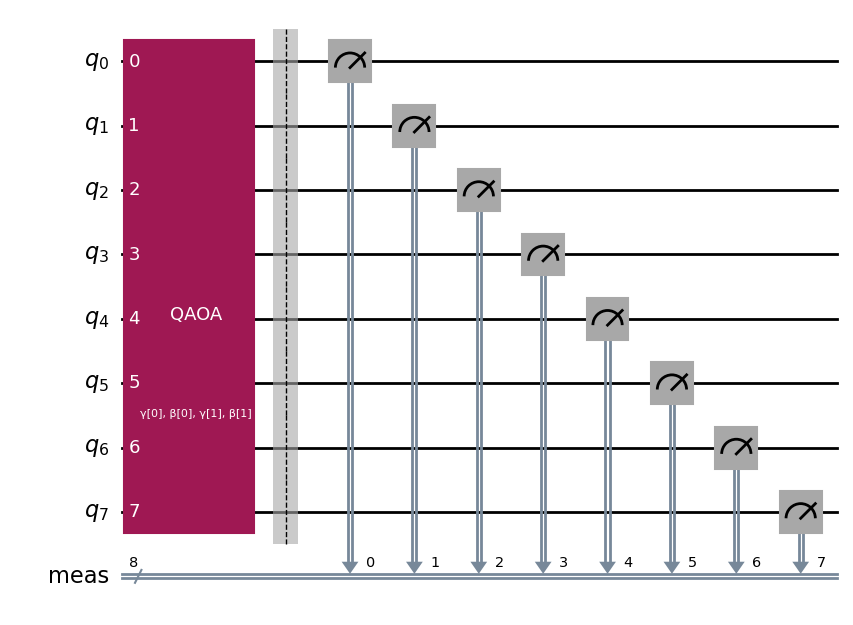

In [4]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw("mpl")

In [5]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

## Step 2. Optimize circuits for quantum hardware execution

The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run on the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

Transpilation may involves several steps, such as:

* **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling.

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on the specified backend.
For simplicity we will use a simulator backend, but this could easily be swapped out for a real quantum computing backend.

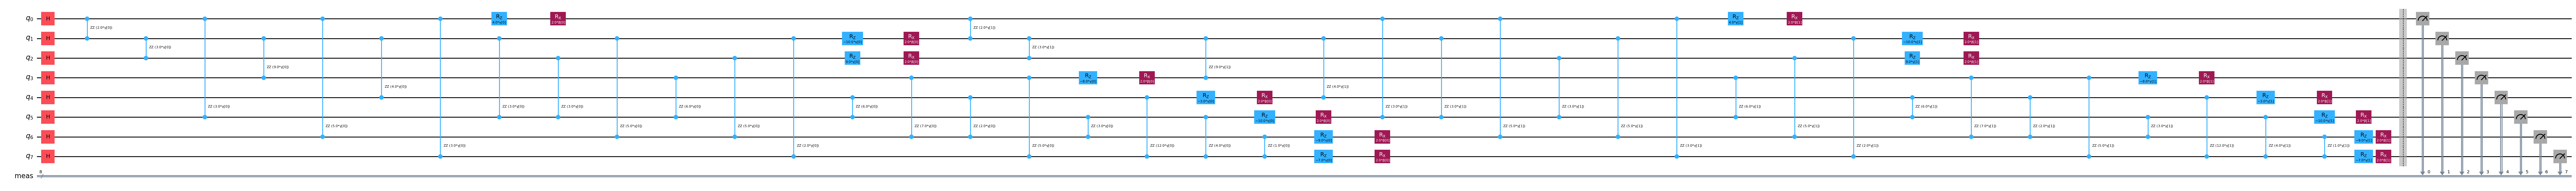

In [6]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Choose backend (this can either be a simulator or a real qc backend.)
backend = AerSimulator()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

## Step 3. Execute using Qiskit primitives

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters.
2. Use a classical optimizer to minimize the expectation value of the cost Hamiltonian, $H_C$, by iteratively adjusting $\beta_k$ and $\gamma_k$.
3. Once the optimizer converges on a set of optimal parameters, execute the circuit one last time to sample the final distribution. The sampled states represent candidate solutions for the optimization problem.


### Step 3.1: Define circuit with initial parameters

We start with an initial guess for the parameters.

In [7]:
init_params = [2.5, 2.5, 0.1, 0.1]
print(init_params)

[2.5, 2.5, 0.1, 0.1]


### Step 3.2 Run optimizer

The two primitives are Sampler and Estimator, and the choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_C$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_C \rangle$.


In [8]:
objective_func_vals = [] # Global variable

def cost_func_estimator(
    params: list, ansatz: "QuantumCircuit", hamiltonian: "ObservablesArrayLike", estimator: "Estimator"
) -> float:

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits for the backend.
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [9]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from scipy.optimize import minimize

estimator = Estimator(mode=backend,options={"default_shots": 4_000})

bounds = [(0, np.pi), (0, np.pi), (0, np.pi), (0, np.pi)]
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    bounds=bounds,
    tol=1e-3,
    options={"rhobeg": 1e-1}
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -23.82091977005749
       x: [ 2.635e+00  2.625e+00  5.093e-02  1.087e-01]
    nfev: 30
   maxcv: 0.0


The optimizer was able to minimize the cost and find better parameters for the circuit.

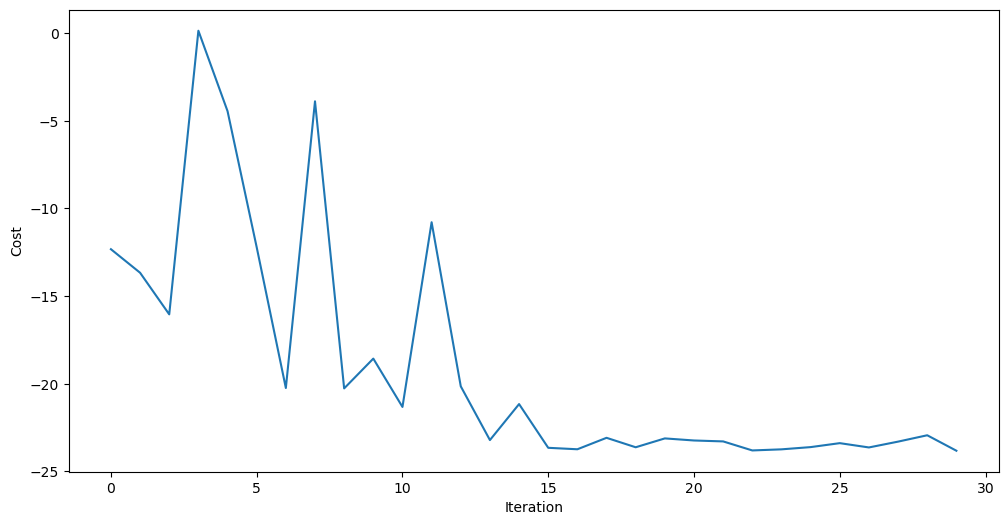

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you have found the optimal parameters for the circuit, you can assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements.

**Note:** This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, `01010100` - which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).


### Step 3.3: Run circuit once more using optimal parameters

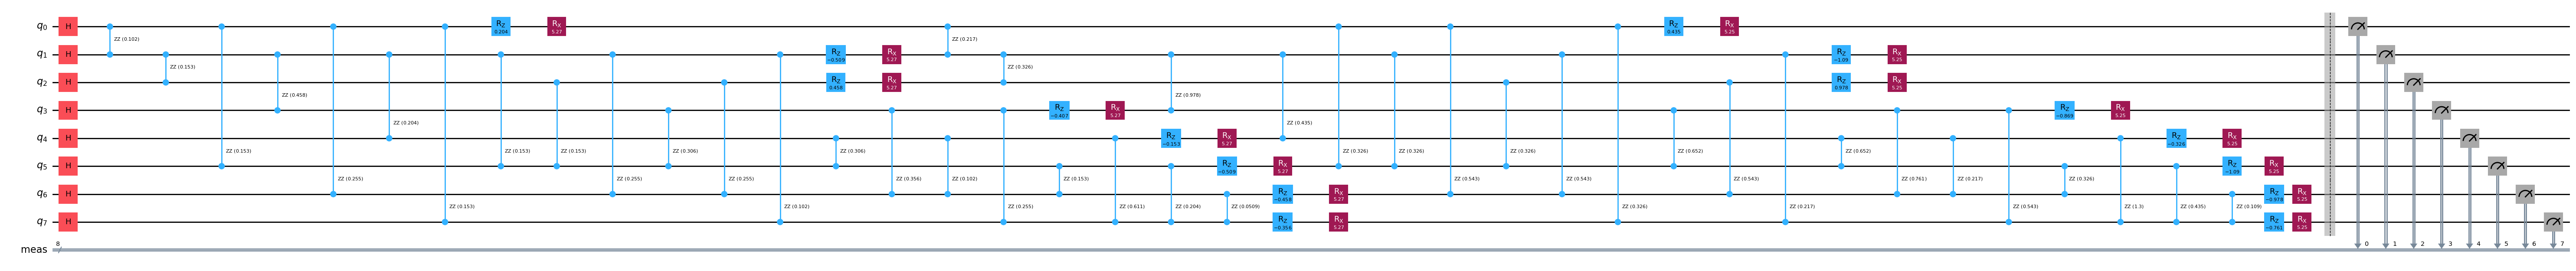

In [11]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend, options={"default_shots": 4_000})

pub = (optimized_circuit,)
job = sampler.run([pub])

In [13]:
counts_bin = job.result()[0].data.meas.get_counts()
shots = job.result()[0].data.meas.num_shots
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_bin)

{'10010100': 0.00825, '00010111': 0.02375, '00011101': 0.242, '10110110': 0.00225, '10000101': 0.05525, '01110100': 0.00175, '00110011': 0.00025, '11000110': 0.004, '10000100': 0.0165, '00000101': 0.03275, '01000000': 0.001, '00010101': 0.067, '00110111': 0.00475, '11100111': 0.0035, '00101101': 0.00125, '11001111': 0.0025, '01100011': 0.0015, '11000101': 0.0095, '10100000': 0.0005, '01011111': 0.003, '10001111': 0.0105, '10100101': 0.01075, '01011100': 0.005, '11100101': 0.0035, '11011101': 0.00225, '10010101': 0.02625, '00001101': 0.00975, '10000111': 0.02375, '10000110': 0.011, '00010100': 0.00575, '11000100': 0.01775, '01010000': 0.00225, '00000111': 0.017, '01100010': 0.00075, '11110100': 0.00475, '01000010': 0.001, '00111101': 0.0055, '11110101': 0.00175, '11101101': 0.002, '00100101': 0.00775, '00011111': 0.01975, '01010101': 0.0145, '00011001': 0.0085, '10110101': 0.0045, '10011101': 0.02675, '00100111': 0.0045, '11100000': 0.0035, '11001101': 0.004, '00110100': 0.0015, '010001

## Step 4. Post-process, return result in classical format

The final step involves interpreting the output of the quantum computation and translating it back into a solution for your original problem. 

When the quantum circuit is executed, it samples from the probability distribution defined by the final quantum state. The output consists of bitstrings, where each bitstring corresponds to a potential solution to the problem. In this step, we:

1. **Filter Solutions**: If any of the sampled bitstrings satisfy the constraints of the original problem (e.g., $f(\vec{x})=(A\vec{x} -\vec{1})^2=0$ for the tail-assignment problem).
2. **Count Occurrences**: Determine the most frequently observed bitstrings and plot a histogram.
   

### Step 4.1: Filter Solutions

We now process the bit-strings sampled from the quantum circuit to determine if any of them satisfy the constraints of the original optimization problem. For each sampled bit-string, we calculate whether it satisfies the problem constraints using the classical cost function $f(\vec{x})$. If and only if this function evaluates to $0$ for a bitstring, a solution exists!

In [14]:
def classical_cost_fun(bit_str: str, A: np.ndarray) -> float:
    # convert binary string to column vector
    x = np.array([[int(bit)] for bit in reversed(bit_str)])
    id_vec = np.ones((A.shape[0], 1))
    return np.sum(np.square(A@x-id_vec), axis=0)[0]

# Look through samples to see if any of the bit strings solve the problem
for bit_str in counts_bin.keys():
    if classical_cost_fun(bit_str, A) == 0:
        print("Valid solution found:", bit_str)
        break

Valid solution found: 00011101


### Step 4.2 Count Occurences

In [15]:
def highest_probability_bitstring(prob_dict: dict) -> (np.ndarray, float):
    """
    Returns the bitstring with the highest probability as a column vector and corresponding probability.

    Args:
        prob_dict (dict): A dictionary where keys are bitstrings (str) and values are probabilities (float).

    Returns:
        (np.ndarray, float): The bitstring with the highest probability and the corresponding probability.
    """
    # Find the key with the highest value
    highest_key = max(prob_dict, key=prob_dict.get)
    highest_value = prob_dict[highest_key]
    return highest_key, highest_value

bit_str, prob = highest_probability_bitstring(final_distribution_bin)

print(f"Most Likely bitstring is {bit_str} with probability {prob*100}%")

Most Likely bitstring is 00011101 with probability 24.2%


We see that QAOA return the solution bit-string with the highest probability. This can be compared to random-guessing, where the probability of obtaining the solution in this case is $1/2^8\approx 0.004$.

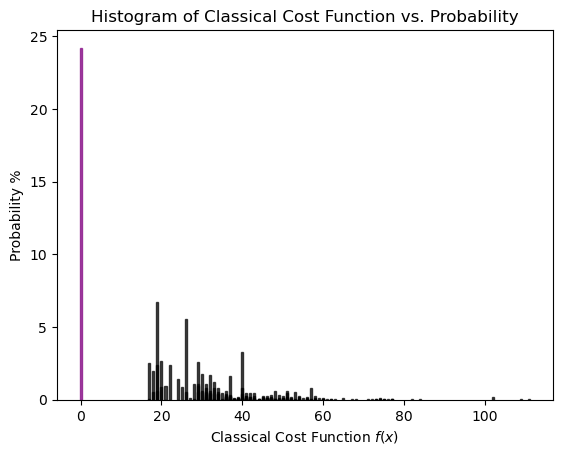

In [16]:
# Compute the classical cost function for all binary bitstrings
costs = []
probabilities = []

for bit_str, prob in final_distribution_bin.items():
    cost = classical_cost_fun(bit_str, A)
    costs.append(cost)
    probabilities.append(prob)

costs = np.array(costs)
probabilities = np.array(probabilities)

# Plot the histogram
colors = ['purple' if cost == 0 else 'black' for cost in costs]
plt.bar(costs, 100*probabilities, width=0.5, color=colors, alpha=0.7, edgecolor=colors)
plt.xlabel(r'Classical Cost Function $f(x)$')
plt.ylabel(r'Probability %')
plt.title('Histogram of Classical Cost Function vs. Probability')
plt.show()

## (Extra): Running a smaller problem on actual quantum computer

In this section, we demonstrate how to run a smaller version of the tail-assignment problem on a real quantum computer. To accommodate the 5-qubit Helmi quantum computer, we load a simplified 2-qubit toy problem.

- Load a Toy Problem: We initialize a smaller version of the tail-assignment problem, ensuring it fits within the qubit limits of the hardware.
- Simulate Performance: Before running the problem on the real hardware, we test the circuit on a simulator to evaluate its behavior under ideal conditions.
- Execute on a Real Backend: Finally, we execute the problem on the Helmi quantum computer to compare results and assess the impact of quantum noise.

By exploring this smaller-scale problem, we get insights into real-world quantum hardware performance and its limitations, while preparing for scaling up to larger problems in the future.

In [17]:
A = np.loadtxt(url + "instance_2.csv", delimiter=',') # load problem data
num_rows, num_cols = A.shape
print(f"Number of flights equals {num_rows}, and number of routes equals {num_cols}.")

Number of flights equals 2, and number of routes equals 2.


In [18]:
Q = QUBO(A)
b = - sum(Q[i,:] + Q[:,i] for i in range(Q.shape[0]))
pauli_terms = generate_pauli_terms(Q, b)
cost_hamiltonian = SparsePauliOp.from_list(pauli_terms)
cost_hamiltonian

SparsePauliOp(['ZZ', 'IZ'],
              coeffs=[0.5+0.j, 0.5+0.j])

In [19]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
candidate_circuit = pm.run(circuit)

# Theoretical pre-calculated optimal parameters
optimal_params = [2.3562, 2.3562, 1.5708, 1.5708]
optimized_circuit = candidate_circuit.assign_parameters(optimal_params)

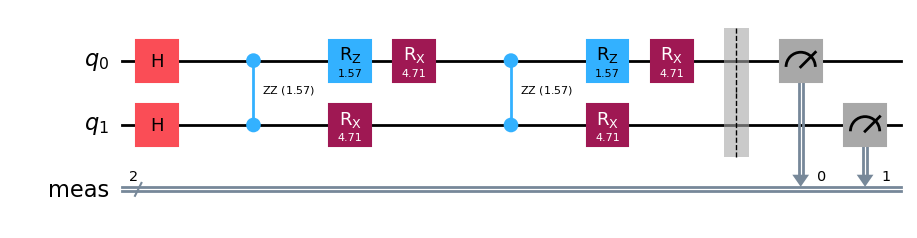

In [20]:
optimized_circuit.draw("mpl")

In [21]:
sampler = Sampler(mode=backend, options={"default_shots": 4_000})
pub = (optimized_circuit,)
job = sampler.run([pub])

In [22]:
counts_bin = job.result()[0].data.meas.get_counts()
shots = job.result()[0].data.meas.num_shots
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
final_distribution_bin

{'01': 1.0}

In [23]:
# Look through samples to see if any of the bit strings solve the problem
for bit_str in counts_bin.keys():
    if classical_cost_fun(bit_str, A) == 0:
        print("Valid solution found:", bit_str)
        break
x, prob = highest_probability_bitstring(final_distribution_bin)

Valid solution found: 01


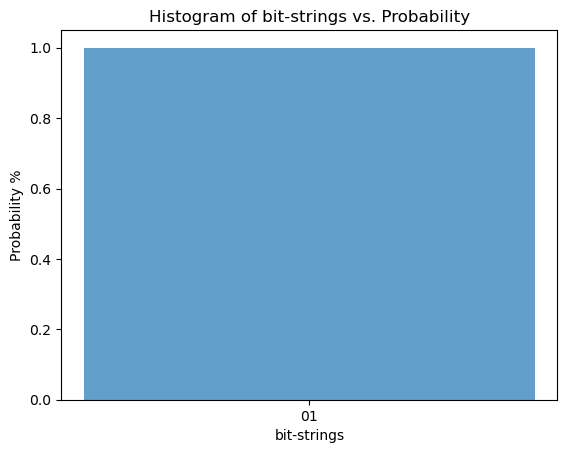

In [24]:
# Plot distrubution of bit-strings.
bins = list(final_distribution_bin.keys())
probabilities = list(final_distribution_bin.values())

# Plot the histogram
plt.bar(bins, probabilities, width=0.5, alpha=0.7)
plt.xlabel(r'bit-strings')
plt.ylabel(r'Probability %')
plt.title('Histogram of bit-strings vs. Probability')
plt.show()

For the 2-qubit toy problem, the QAOA algorithm correctly identifies the optimal solution bit-string with 100% probability in the simulation using 2-layers. This result is under ideal conditions, where noise and hardware imperfections are absent.

### Running QAOA on the HELMI quantum computer

In [25]:
import os
from iqm.qiskit_iqm import IQMProvider

HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')  # This is set when loading the module
provider = IQMProvider(HELMI_CORTEX_URL)
backend = provider.get_backend()

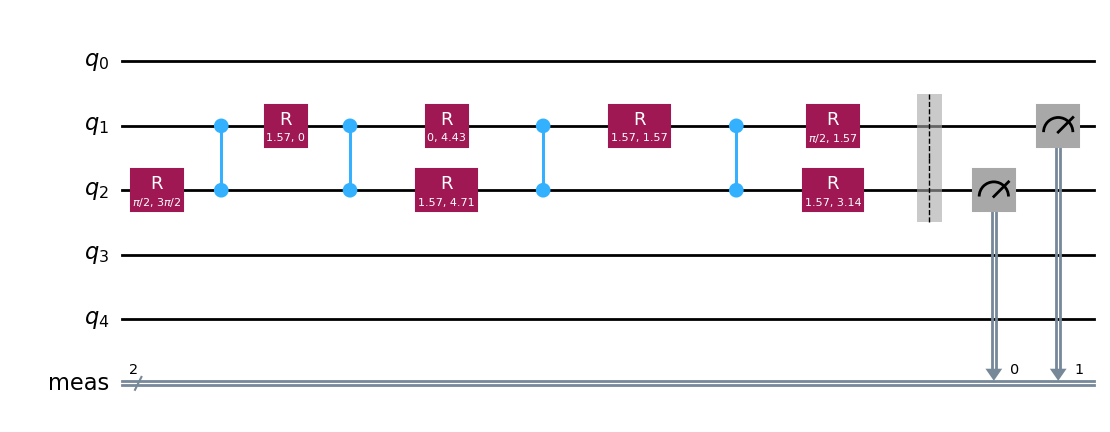

In [29]:
from qiskit.compiler import transpile
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates

transpiled_circuit = transpile(circuit, backend, optimization_level=3)
optimized_transpiled_circuit = optimize_single_qubit_gates(transpiled_circuit.assign_parameters(optimal_params))
optimized_transpiled_circuit.draw("mpl")

In [30]:
job = backend.run(optimized_transpiled_circuit)

In [31]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [32]:
counts_bin = job.result().data()["counts"]
shots = job.result().results[0].shots
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
final_distribution_bin

{'01': 0.7080078125,
 '11': 0.2880859375,
 '00': 0.0029296875,
 '10': 0.0009765625}

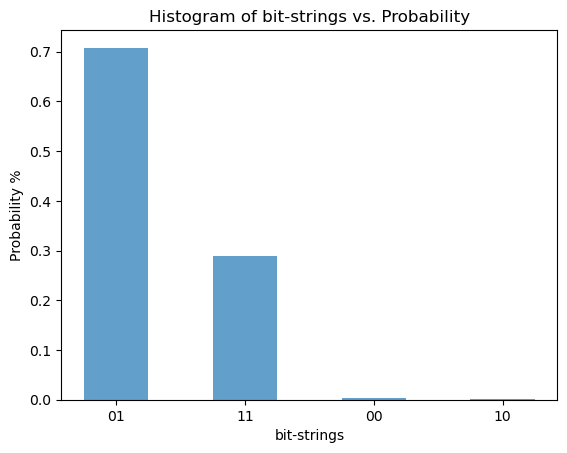

In [33]:
# Plot distrubution of bit-strings.
bins = list(final_distribution_bin.keys())
probabilities = list(final_distribution_bin.values())

# Plot the histogram
plt.bar(bins, probabilities, width=0.5, alpha=0.7)
plt.xlabel(r'bit-strings')
plt.ylabel(r'Probability %')
plt.title('Histogram of bit-strings vs. Probability')
plt.show()

## Conclusion

This tutorial demonstrated how to solve the tail-assignment problem using Qiskit. While quantum computers currently do not outperform classical computers for combinatorial optimization tasks—primarily due to noise and hardware limitations—progress in this field is advancing rapidly. 

The hardware is steadily improving, with new algorithms continually being developed. Many of these quantum heuristics are currently tested on classical simulators, which are limited to small problem sizes (typically around 20 qubits). 

In the near future, as quantum computers with more qubits and less noise, it will become feasible to benchmark quantum heuristics on larger, real-world problem instances. This progress holds the potential to unlock new capabilities in solving challenging optimization problems that are intractable by classical methods.